# == Pre-trained CNN for binary Classification + Data Augmentation ==


In [1]:
# Computational Intelligence Project
# Dipartimento di Ingegneria dell´Informazione , Universita´ di Pisa
# Authors: Rachele Nebbia Colomba, Alessandro Gentili, Giorgio Simonini
#    begin                : June 2020
#    copyright            : (C)  2020 Universita´ di pisa    
#    email                : rachelenebbia <at> gmail <dot> com

# Import libraries 
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
print(keras.__version__)
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import metrics
import os
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from google.colab import drive
from tensorflow.keras.models import load_model


TensorFlow 1.x selected.
1.15.2
2.2.4-tf


Using TensorFlow backend.


In [ ]:
#Function to shuffle the tuples and have random order of the classes in training dataset
def mischia(img,lab):
    z=list(zip(img,lab)) #zip returns an iterator instead and needs to be passed to a list function to get the zipped tuples
    rnd.shuffle(z) #random shuffle of the tuples
    img2,lab2=zip(*z) #unzipping, it obtaines the original form 
    img2=np.asarray(img2)
    lab2=np.asarray(lab2)
    return img2,lab2

In [3]:
# Import data
drive.mount('/content/drive/')

dir_numpy ="/content/drive/My Drive/Computational/numpy data"
dir_nets ="/content/drive/My Drive/Computational/networks"
dir_check ="/content/drive/My Drive/Computational/networks"
dir_preModel ="/content/drive/My Drive/Computational/altro"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


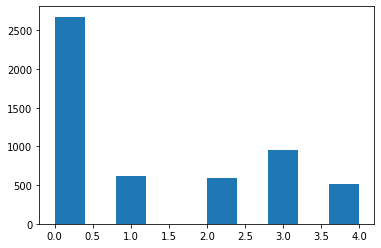

5352 images


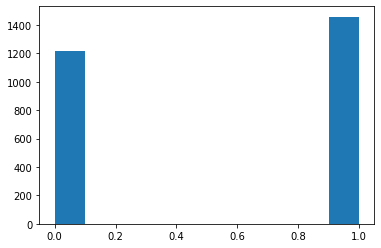

2676 images


In [4]:
# Load tensor for Training Dataset (images+labels) and Testing Dataset (images+labels)
train_img = np.load(os.path.join(dir_numpy,'train_tensor.npy'))
train_lab = np.load(os.path.join(dir_numpy,'train_labels.npy'))
test_img = np.load(os.path.join(dir_numpy,'public_test_tensor.npy'))
test_lab = np.load(os.path.join(dir_numpy,'public_test_labels.npy'))

# Plot histogram to visualize classes distribution of Dataset
plt.hist(train_lab)
plt.show()
print(len(train_lab), "images")

# Here define new tensors to divide between massesn and calcifications:
# Labels legend --> 2 = masses, 4 = calcifications.
n_img=len(train_img)
train_img_31=train_img[1:n_img:2]
n_img_test=len(test_img)
test_img_31=test_img[1:n_img_test:2]
# From tensor get labels
train_lab_31=train_lab[1:n_img:2]
test_lab_31=test_lab[1:n_img_test:2]
n_img31=len(train_img_31)

# Processing: reassign labels to have mass = 0, calcification = 1
for i in range(0,n_img31):
    if ((train_lab_31[i] == 1) or (train_lab_31[i] == 2)):
        train_lab_31[i] = 0
    elif ((train_lab_31[i] == 3) or (train_lab_31[i] == 4)):
        train_lab_31[i] = 1
n_img31_test=len(test_img_31)
for i in range(0,n_img31_test):
    if ((test_lab_31[i] == 1) or (test_lab_31[i] == 2)):
        test_lab_31[i] = 0
    elif ((test_lab_31[i] == 3) or (test_lab_31[i] == 4)):
        test_lab_31[i] = 1
#Plot histogram to visualize data distribution 
plt.hist(train_lab_31)
plt.show()
print(len(train_lab_31), "images")

In [5]:
# Import Neural network VGG16
# VGG16 was previously trained on large data-sets and we re-purpose it by transfer leaning weights trained from two different data-sets: Imagenet and Chest-Xray-Pneumonia.

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

conv_base_pretrained = VGG16(weights='imagenet',
                            include_top=False,
                            input_shape=(150, 150, 3))
# Import weights from larger Datasets 
# Show summary of NN structure 
conv_base_pretrained.load_weights('/content/drive/My Drive/Computational/altro/weights_chest.h5')
conv_base_pretrained.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

In [6]:
# Transfer-learning technique by unfreezing the last convolutional blocks and adding a dense layer on bottom.
# Imporrt model:
from keras.models import Model
conv_base_pretrained.trainable = True
set_trainable = False
for layer in conv_base_pretrained.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
# Visualize summary of NN structure 
conv_base = conv_base_pretrained
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
# Shape the CNN: adde dense layer and type of activation 
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
shape=(None, 150, 150, 3)
model.build(shape)
# Visualize summary of Pre-trained CNN structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 11,274,753
Non-trainable params: 7,635,264
_________________________________________________________________


float32


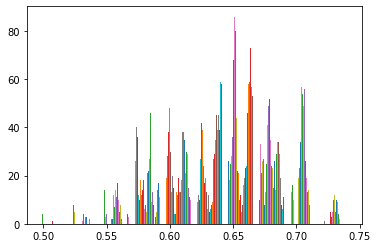

(336, 150, 150, 1)

In [8]:
# Normalite train and test images 
train_img_31 = train_img_31.astype('float32') / 65535
test_img_31 = test_img_31.astype('float32') / 65535

# Visualize processing
print(train_img_31[5,:].dtype) # check the type
plt.hist(train_img_31[5,:]) # check the value range and the distribution
plt.show()

# reshape datasets 
train_img_31 = train_img_31.reshape((n_img31, 150, 150, 1))
test_img_31 = test_img_31.reshape((n_img31_test, 150, 150, 1))
# check tensors 
test_img_31.shape

In [9]:
# reshap train dataset 
train_lab_31.shape

(2676,)

In [10]:
# Visualize labels for first 100 samples
train_lab_31.shape
print(train_lab_31[0:100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# Shuffle samples to have random order of classes
train_img_31, train_lab_31 = mischia(train_img_31, train_lab_31)
train_lab_31.shape
# Visualize first 100 samples after shuffling 
print(train_lab_31[0:100])

[1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1
 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1]


In [ ]:
# Function to tranform from gray to RGB images
def gray_to_rgb(img):
    return np.repeat(img, 3, 2)

In [ ]:
# Data augmentation
# Idea: reshape, modify something of the images to augment the DATAset
BATCH_SIZE = 50
# new augmented dataset
train_RGB = np.ndarray(shape=(train_img_31.shape[0], train_img_31.shape[1], train_img_31.shape[2], 3), dtype= np.float32) #dummy RGB images
train_RGB[:, :, :, 0] = train_img_31[:, :, :, 0]
train_RGB[:, :, :, 1] = train_img_31[:, :, :, 0]
train_RGB[:, :, :, 2] = train_img_31[:, :, :, 0]

test_RGB = np.ndarray(shape=(test_img_31.shape[0], test_img_31.shape[1], test_img_31.shape[2], 3), dtype= np.float32) #dummy RGB images
test_RGB[:, :, :, 0] = test_img_31[:, :, :, 0]
test_RGB[:, :, :, 1] = test_img_31[:, :, :, 0]
test_RGB[:, :, :, 2] = test_img_31[:, :, :, 0]

# Generate new images for training Dataset 
val_img_31 = train_RGB[2400:2675]
val_lab_31 = train_lab_31[2400:2675]
train_img_31b = train_RGB[0:2399]
train_lab_31b = train_lab_31[0:2399]

train_datagen = ImageDataGenerator(
    #preprocessing_function=gray_to_rgb,
    rotation_range=180,
    zoom_range=0.1,
    vertical_flip=True,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!

train_generator = train_datagen.flow(
        train_img_31b,
        train_lab_31b,
        batch_size=BATCH_SIZE)

validation_generator = val_datagen.flow(
        val_img_31,
        val_lab_31,
        batch_size=BATCH_SIZE)

In [14]:
# Define NN optimizer and compile the model 
opt=optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, amsgrad=False)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
# Define check point, number of epochs and criteria of stopping
file_check ="/content/drive/My Drive/Computational/networks/checkpoint31b"
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=10)
checkpoint = ModelCheckpoint(file_check, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
      train_generator,
      steps_per_epoch=2400//BATCH_SIZE,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=276//BATCH_SIZE,
      callbacks=[checkpoint],
      shuffle = True)


Epoch 1/50
 5/48 [==>...........................] - ETA: 6s - loss: 0.5881 - acc: 0.7560
Epoch 00001: val_acc improved from -inf to 0.75600, saving model to /content/drive/My Drive/Computational/networks/checkpoint31b
48/48 [==============================] - 32s 659ms/step - loss: 0.7337 - acc: 0.5477 - val_loss: 0.5881 - val_acc: 0.7560
Epoch 2/50
 5/48 [==>...........................] - ETA: 5s - loss: 0.4544 - acc: 0.7880
Epoch 00002: val_acc improved from 0.75600 to 0.78800, saving model to /content/drive/My Drive/Computational/networks/checkpoint31b
48/48 [==============================] - 15s 313ms/step - loss: 0.4931 - acc: 0.7637 - val_loss: 0.4544 - val_acc: 0.7880
Epoch 3/50
 5/48 [==>...........................] - ETA: 5s - loss: 0.4218 - acc: 0.8120
Epoch 00003: val_acc improved from 0.78800 to 0.81200, saving model to /content/drive/My Drive/Computational/networks/checkpoint31b
48/48 [==============================] - 15s 321ms/step - loss: 0.4265 - acc: 0.8074 - val_loss:

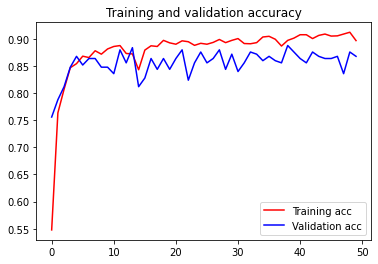

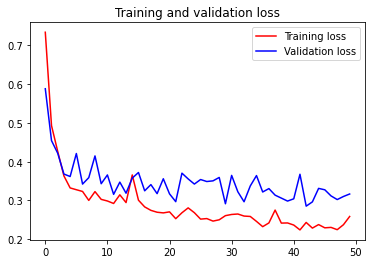

In [25]:
# Visualize results
acc = history.history['acc'] 
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot training and validation accuracy 
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
# Evaluate results on Test Dataset
test_loss, test_acc = model.evaluate(test_RGB, test_lab_31)

336/336 [==============================] - 4s 10ms/sample - loss: 0.3293 - acc: 0.8631


In [ ]:
#ckmodel.save(os.path.join(dir_nets,"net_31b.h5"))

In [19]:
ckmodel = load_model(os.path.join(dir_check,"checkpoint31b"))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
test_loss, test_acc = ckmodel.evaluate(test_RGB, test_lab_31)

336/336 [==============================] - 1s 3ms/sample - loss: 0.3268 - acc: 0.8631


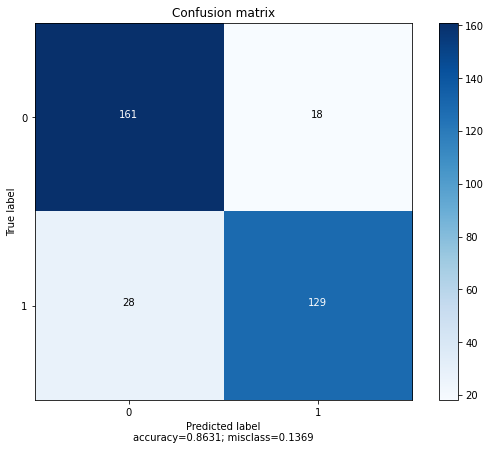

In [22]:
# Results evaluation: 
# Confusion Matrix plot
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
#Plotting of the Matrix confusion
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools
 
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    cmap = plt.get_cmap('Blues')
 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xticks(range(0,2),)
    plt.yticks(range(0,2),)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
 
y_pred=ckmodel.predict(test_RGB)
for i in range(len(test_lab_31)):
  if y_pred[i] <= 0.5:
    y_pred[i]=0
  else:
    y_pred[i]=1
conf_mtx = confusion_matrix(test_lab_31,y_pred) 
plot_confusion_matrix(conf_mtx,normalize=False)

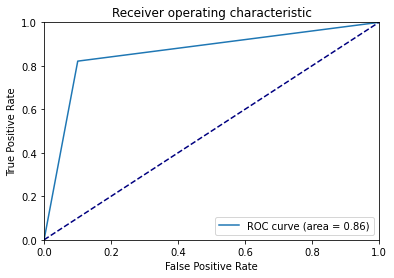

In [23]:
# Results evaluation: 
# ROC Curve plot
fpr,tpr,th = metrics.roc_curve(test_lab_31,y_pred)
# Sensitivty = TPR(True Positive Rate)= Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate)= FP/(TN+FP)
roc_auc = metrics.roc_auc_score(test_lab_31,y_pred)
from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()